# LSTM Approach

## Why LSTM?
- It was introduced for solving the problem of vanishing/exploiting gradients (RNN)
- As the RNN, it can be used for inputs with variable lengths
- The order matters


### Vanishing/Exploiting gradients
Basically, the RNN can't exploit long term dependencies, in fact when we compute the gradient with respect to the first inputs for an hidden layer that is far away in the time, we see that the gradients can be or close to 0 or close to inf due to the matrix multiplication of the recursive step done many times!

Let's start!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#from keras.callbacks import EarlyStopping

In [2]:
PATH = "/Users/simoneboesso/Desktop/US_GDP-Time-Series-Forecast/US-GDP/GDPUS_nsa.csv"
df = pd.read_csv(PATH)

In [3]:
df.head()

,DATE,NA000334Q
0,1947-01-01,58497.0
1,1947-04-01,60672.0
2,1947-07-01,62196.0
3,1947-10-01,68250.0
4,1948-01-01,64258.0


In [4]:
df['DATE'] = pd.to_datetime(df['DATE'])
print(df.dtypes)

DATE         datetime64[ns]
NA000334Q           float64
dtype: object


In [5]:
df.set_index('DATE', inplace=True) 

In [6]:
df = df.asfreq(pd.infer_freq(df.index))

In [7]:
df.head()

,NA000334Q
DATE,
1947-01-01,58497.0
1947-04-01,60672.0
1947-07-01,62196.0
1947-10-01,68250.0
1948-01-01,64258.0


In [8]:
from datetime import datetime,timedelta

start_date = datetime(1947,1,1)
end_date = datetime(2020,1,1)
df = df[start_date:end_date]

Let's split in train and test!

In [9]:
train_end = datetime(2015,1,1)
test_end = datetime(2020,1,1)

train_data = df[:train_end]
train_data  = np.log(train_data) # performing the log transform
test_data = df[train_end + timedelta(days=1):test_end]
test_data = np.log(test_data) # performing the log transform

In [10]:
train_data.head()

,NA000334Q
DATE,
1947-01-01,10.976731
1947-04-01,11.013238
1947-07-01,11.038046
1947-10-01,11.130933
1948-01-01,11.070662


Now, let's create the sequences used for training and testing!

In [11]:
'''
This is used for create a rolling windows of size seq_size;
eg. l = [4,2,6,3,5] 
and
seq_size = 2
x1 = [4,2], y1 = 6
'''
def to_sequences(dataset, seq_size=1):
    dataset = dataset.reset_index(drop=True)
    x = []
    y = []
    for i in range(len(dataset)-seq_size-1):
        window = dataset.iloc[i:(i+seq_size)]
        y.append(dataset.iloc[i+seq_size])
        x.append(window)
    return np.array(x),np.array(y)

In [12]:
X_train,y_train = to_sequences(train_data,2)

### Checks

In [13]:
X_train[0]

array([[10.97673075],
       [11.01323759]])

In [14]:
y_train[0]

array([11.03804597])

In [15]:
X_train[1]

array([[11.01323759],
       [11.03804597]])

In [16]:
seq_size = 10
X_train,y_train = to_sequences(train_data,seq_size)
X_test,y_test = to_sequences(test_data,seq_size)

In [17]:
print("Shape of training set: {}".format(X_train.shape))
print("Shape of test set: {}".format(X_test.shape))


Shape of training set: (262, 10, 1)
Shape of test set: (9, 10, 1)


# Model: LSTM

In [ ]:
# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

model = Sequential()
model.add(LSTM(64, input_shape=(None, seq_size)))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='MSE', optimizer='adam',metrics=['mse'])

model.summary()
print('Train...')
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
          verbose=2, epochs=100)

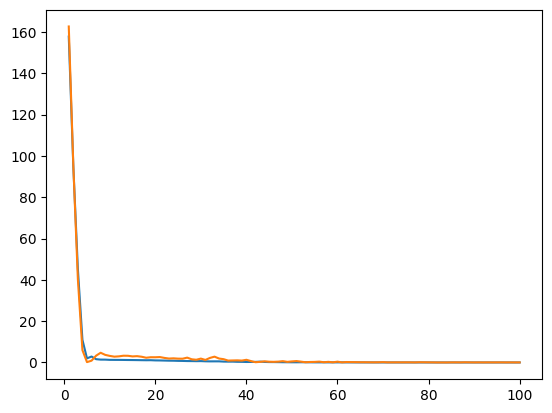

In [19]:
max_epoch = len(history.history['mse'])+1
epoch_list = list(range(1,max_epoch))
plt.plot(epoch_list, history.history['mse'], label='Train MSE')
plt.plot(epoch_list, history.history['val_mse'], label='Validation MSE')
plt.show()

In [20]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [21]:
testScore = math.sqrt(mean_squared_error(y_test, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 0.20 RMSE


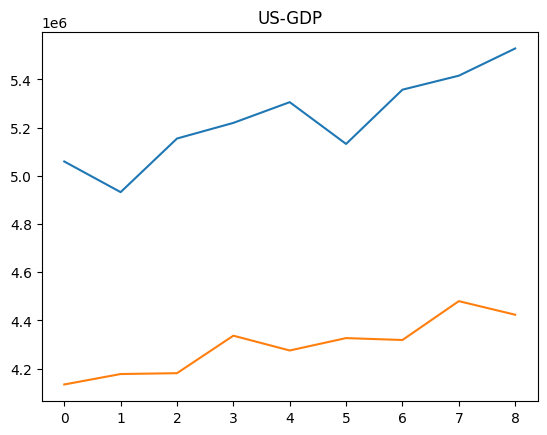

In [22]:
plt.plot(np.exp(y_test))
plt.plot(np.exp(testPredict))
plt.title("US-GDP")
plt.show()